In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import tensorflow_privacy
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras import layers
from keras import backend as K
tf.random.set_seed(42)

In [2]:
train, test = tf.keras.datasets.mnist.load_data()
train_data, train_labels = train
test_data, test_labels = test

train_data = np.array(train_data, dtype=np.float32)/255
test_data = np.array(test_data, dtype=np.float32)/255

train_data = train_data.reshape(train_data.shape[0],28,28,1) # angka 1 dibelakang menunjukkan color channel. Hanya ada 1 color channel
test_data = test_data.reshape(test_data.shape[0],28,28,1)

train_labels = np.array(train_labels, dtype = np.int32)
test_labels = np.array(test_labels, dtype = np.int32)

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = 10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = 10)

#check data distribution, normalized since divided by 255
assert train_data.min() == 0
assert train_data.max() == 1
assert test_data.min() == 0
assert test_data.max() == 1

## Defining Functions

In [3]:
def dp_sgd(l2_norm_clip,noise_multiplier,num_microbatches,learning_rate):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,8,
                              strides = 2,
                              padding = 'same',
                              activation = 'relu',
                              input_shape = (28,28,1)),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Conv2D(32,4,
                               strides = 2,
                               padding = 'valid',
                               activation = 'relu'),
        tf.keras.layers.MaxPool2D(2,1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    
    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip = l2_norm_clip,
        noise_multiplier = noise_multiplier,
        num_microbatches = num_microbatches,
        learning_rate = learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy(
        from_logits = False, reduction = tf.losses.Reduction.NONE)
    model.compile(optimizer = optimizer , loss = loss, metrics = ['accuracy'])
    return model

def getlayeroutput(model,data,index):
    from keras import backend as K
    getoutput = K.function([model.layers[0].input],[model.layers[index].output])
    return getoutput([data])[0]

def discriminator(in_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(in_shape*1.25,input_dim = in_shape,
                              activation = 'relu'),
        tf.keras.layers.Dense(in_shape*2,input_dim = in_shape,activation = 'relu'),
        tf.keras.layers.Dense(in_shape*1.5,activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                 metrics = 'accuracy')
    return model

def discriminatortrue(in_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(in_shape*1.25,input_dim = in_shape,
                              activation = 'relu'),
        tf.keras.layers.Dense(in_shape*2,activation = 'relu'),
        tf.keras.layers.Dense(in_shape*1.5,activation = 'relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(in_shape*2,activation = 'relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer,
                 metrics = 'accuracy')
    return model

def generator(in_shape):
    model = tf.keras.Sequential([
        #tf.keras.layers.Dense(16,input_dim = in_shape),
        tf.keras.layers.Conv1D(16,2,activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv1D(32,2,activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv1D(64,2,activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(32,activation='relu'),
        tf.keras.layers.Dense(10,activation='linear'),
    ])
    return model
    
def GAN(gen,dis):
    dis.trainable = False
    model = tf.keras.Sequential([ 
        gen,
        dis
    ])
    opt = tf.keras.optimizers.Adam()
    model.compile(loss='binary_crossentropy',optimizer=opt)
    
    return model


def generate_fake_samples(gen, data, batch):
    x_input = np.random.randn(batch,data.shape[1])
    x_input = np.expand_dims(x_input, axis=2)
    x = gen.predict(x_input)
    y = np.zeros((batch,1))
    
    return x.reshape(batch,data.shape[1]),y

def shuffledata(xdata,ydata):
    indices = tf.range(start=0,limit=tf.shape(xdata)[0], dtype = tf.int32)
    idx = tf.random.shuffle(indices)
    return tf.gather(xdata,idx) , tf.gather(ydata,idx)

def train(gen, dis, distrue, gan, output_noise, output_true, n_epochs= 10000, n_batch = 512):
    #determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch/2)
    dishist=[]
    genhist=[]
    disacchist = []
    distrueacchist = []
    
    ### HUGE NOTE: Normalmodel is 1, DPmodel is 0
    
    #train the true discriminator to the DPmodel and Normalmodel data
    distrue_output_true_train_x = output_true[:] #setting x data from normalmodel for true discriminant
    distrue_output_true_train_y = np.ones((output_true.shape[0],1)) #setting y data from normalmodel for true discriminant
    
    distrue_output_noise_train_x = output_noise[:] #setting x data from DPmodel for true discriminant
    distrue_output_noise_train_y = np.zeros((output_noise.shape[0],1)) #setting y data from DPmodel for true discriminant
    
    #combine
    distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
    distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()
    
    #shuffle
    distruex_shuffle, distruey_shuffle = shuffledata(distruex,distruey)
    distrue.fit(distruex_shuffle,distruey_shuffle)
    
    #manually enumerate epochs
    for epoch in range(n_epochs):
        ###########################################################################################################      
        ##GAN PART
        #prepare samples      
        #Normalmodel data
        x_real = output_true[np.random.choice(output_true.shape[0], half_batch, replace=False), :]
        y_real = np.ones((half_batch,1))
        
        #Normalmodel data upsampled (fake)
        x_fake, y_fake = generate_fake_samples(gen, output_true, half_batch)
        
        #combined
        disx = pd.DataFrame(x_real).append(pd.DataFrame(x_fake),ignore_index = True).to_numpy()
        disy = pd.DataFrame(y_real).append(pd.DataFrame(y_fake),ignore_index = True).to_numpy()
        
        #shuffle
        disx_shuffle, disy_shuffle = shuffledata(disx,disy)
        
        #update discriminator
        disloss, disacc = dis.train_on_batch(disx_shuffle,disy_shuffle)
        
        #input for gan
        noise = np.random.randn(n_batch,output_true.shape[1])
        noise = np.expand_dims(noise, axis=2)
        y_gen = np.ones((n_batch,1))
        
        #update generator from discriminator error
        gen_loss_fake = gan.train_on_batch(noise,y_gen)
        
        ###########################################################################################################
        ##TRUE DISCRIMINANT PART
        #Check the true discriminator performance
        #Normalmodel data upsampled (fake)
        distrue_output_true_x = x_fake[:]
        distrue_output_true_y = y_fake[:]
        distrue_output_true_y[:] = 1
    
        #DPmodel data
        distrue_output_noise_x = output_noise[np.random.choice(output_noise.shape[0], half_batch, replace=False), :]
        distrue_output_noise_y = np.zeros((distrue_output_true_y.shape[0],0))
        
        #aggregated
        distruex_test = pd.DataFrame(distrue_output_true_x).append(pd.DataFrame(distrue_output_noise_x),ignore_index = True).to_numpy()
        distruey_test = pd.DataFrame(distrue_output_true_y).append(pd.DataFrame(distrue_output_noise_y),ignore_index = True).to_numpy()
        
        
        distrueloss, distrueacc = distrue.test_on_batch(distruex_test,distruey_test)
        
        print('>%d, discriminant_loss=%.3f discriminant_acc=%.3f generator_loss=%.3f true_discriminant_acc=%.3f' % (epoch+1, disloss, disacc, gen_loss_fake, distrueacc))
        
        dishist.append(disloss)
        genhist.append(gen_loss_fake)
        disacchist.append(disacc)
        distrueacchist.append(distrueacc)
    plot_history(dishist,genhist,disacchist,distrueacchist)
    
    #final accuracy of True Discriminant
    output_true_upsampled_x, output_true_upsampled_y = generate_fake_samples(gen, output_true, output_true.shape[0])
    output_true_upsampled_y[:] = 1
    
    output_noise_x, output_noise_y = output_noise[:], np.zeros((output_noise.shape[0],1))
    
    distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
    distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()
    
    #shuffle
    distruex_final_shuffle, distruey_final_shuffle = shuffledata(distruex_final,distruey_final)
    
    fin_loss, fin_acc = distrue.test_on_batch(distruex_final_shuffle, distruey_final_shuffle)
    
    print("Final True Discriminant Accuracy: %.3f" % fin_acc)
        
        
def plot_history(d_hist, g_hist, dacc_hist, dacc2_hist):
    # plot loss    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(d_hist, label='discriminator_loss')
    plt.plot(g_hist, label='generator_loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.subplot(212)
    plt.plot(dacc_hist, label='GAN_discriminator_accuracy')
    plt.plot(dacc2_hist, label='True_discriminator_accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.show()
    plt.close()

## Training Original Model 

##### DPmodel & Normalmodel

In [ ]:
DPmodel = dp_sgd(l2_norm_clip = 1.5, noise_multiplier = 1.6, 
                 num_microbatches = 50, learning_rate = 0.25)
Normalmodel = dp_sgd(l2_norm_clip = 1.5, noise_multiplier = 1, 
                 num_microbatches = 50, learning_rate = 0.25)

DPmodel.fit(train_data, train_labels, 
            epochs = 5, batch_size = 250,
            validation_data = (test_data, test_labels))

Normalmodel.fit(train_data, train_labels, 
                epochs = 5, batch_size = 250,
                validation_data = (test_data, test_labels))

Epoch 1/5
240/240 [==============================] - 152s 538ms/step - loss: 1.0138 - accuracy: 0.6874 - val_loss: 0.8917 - val_accuracy: 0.8094
Epoch 2/5
240/240 [==============================] - 153s 638ms/step - loss: 1.0270 - accuracy: 0.8081 - val_loss: 1.1827 - val_accuracy: 0.7955
Epoch 3/5
228/240 [===========================>..] - ETA: 7s - loss: 1.2096 - accuracy: 0.7790

##### DP Model Privacy

In [ ]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=250,
                                              noise_multiplier=1.6,
                                              epochs=5,
                                              delta=1e-5)

##### Normal Model Privacy

In [ ]:
compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=train_data.shape[0],
                                              batch_size=250,
                                              noise_multiplier=1,
                                              epochs=5,
                                              delta=1e-5)

## Proceed with GAN

In [10]:
output_model_noise = DPmodel.predict(train_data)
output_model_true = Normalmodel.predict(train_data)

1875/1875 [==============================] - 5s 3ms/step


C:\Windows\Temp\ipykernel_22888\3476477901.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex = pd.DataFrame(distrue_output_true_train_x).append(pd.DataFrame(distrue_output_noise_train_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_22888\3476477901.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey = pd.DataFrame(distrue_output_true_train_y).append(pd.DataFrame(distrue_output_noise_train_y),ignore_index = True).to_numpy()


8/8 [==============================] - 0s 3ms/step


C:\Windows\Temp\ipykernel_22888\3476477901.py:142: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  disx = pd.DataFrame(x_real).append(pd.DataFrame(x_fake),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_22888\3476477901.py:143: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  disy = pd.DataFrame(y_real).append(pd.DataFrame(y_fake),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_22888\3476477901.py:172: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_test = pd.DataFrame(distrue_output_true_x).append(pd.DataFrame(distrue_output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_22888\3476477901.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in

>1, discriminant_loss=0.669 discriminant_acc=0.643 generator_loss=0.684 true_discriminant_acc=0.336
8/8 [==============================] - 0s 3ms/step
>2, discriminant_loss=0.671 discriminant_acc=0.525 generator_loss=0.671 true_discriminant_acc=0.248
8/8 [==============================] - 0s 3ms/step
>3, discriminant_loss=0.678 discriminant_acc=0.488 generator_loss=0.658 true_discriminant_acc=0.182
8/8 [==============================] - 0s 3ms/step
>4, discriminant_loss=0.679 discriminant_acc=0.500 generator_loss=0.643 true_discriminant_acc=0.100
8/8 [==============================] - 0s 3ms/step
>5, discriminant_loss=0.685 discriminant_acc=0.500 generator_loss=0.626 true_discriminant_acc=0.076
8/8 [==============================] - 0s 3ms/step
>6, discriminant_loss=0.693 discriminant_acc=0.486 generator_loss=0.609 true_discriminant_acc=0.049
8/8 [==============================] - 0s 4ms/step
>7, discriminant_loss=0.701 discriminant_acc=0.488 generator_loss=0.591 true_discriminant_acc=

8/8 [==============================] - 0s 3ms/step
>109, discriminant_loss=0.689 discriminant_acc=0.688 generator_loss=0.712 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>110, discriminant_loss=0.684 discriminant_acc=0.705 generator_loss=0.710 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>111, discriminant_loss=0.682 discriminant_acc=0.734 generator_loss=0.709 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>112, discriminant_loss=0.684 discriminant_acc=0.719 generator_loss=0.708 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>113, discriminant_loss=0.680 discriminant_acc=0.729 generator_loss=0.708 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>114, discriminant_loss=0.679 discriminant_acc=0.738 generator_loss=0.707 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>115, discriminant_loss=0.673 d

8/8 [==============================] - 0s 3ms/step
>163, discriminant_loss=1.007 discriminant_acc=0.273 generator_loss=0.324 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>164, discriminant_loss=1.036 discriminant_acc=0.242 generator_loss=0.291 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>165, discriminant_loss=1.052 discriminant_acc=0.232 generator_loss=0.308 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>166, discriminant_loss=1.085 discriminant_acc=0.217 generator_loss=0.293 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>167, discriminant_loss=1.099 discriminant_acc=0.205 generator_loss=0.289 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>168, discriminant_loss=1.126 discriminant_acc=0.213 generator_loss=0.280 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>169, discriminant_loss=1.153 d

8/8 [==============================] - 0s 3ms/step
>217, discriminant_loss=0.634 discriminant_acc=0.500 generator_loss=1.030 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>218, discriminant_loss=0.642 discriminant_acc=0.500 generator_loss=1.023 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>219, discriminant_loss=0.646 discriminant_acc=0.500 generator_loss=1.008 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>220, discriminant_loss=0.642 discriminant_acc=0.500 generator_loss=0.994 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>221, discriminant_loss=0.651 discriminant_acc=0.498 generator_loss=0.985 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>222, discriminant_loss=0.644 discriminant_acc=0.500 generator_loss=0.990 true_discriminant_acc=0.500
8/8 [==============================] - 0s 5ms/step
>223, discriminant_loss=0.647 d

8/8 [==============================] - 0s 3ms/step
>271, discriminant_loss=0.686 discriminant_acc=0.553 generator_loss=0.771 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>272, discriminant_loss=0.685 discriminant_acc=0.564 generator_loss=0.772 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>273, discriminant_loss=0.687 discriminant_acc=0.566 generator_loss=0.771 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>274, discriminant_loss=0.686 discriminant_acc=0.559 generator_loss=0.772 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>275, discriminant_loss=0.683 discriminant_acc=0.564 generator_loss=0.773 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>276, discriminant_loss=0.684 discriminant_acc=0.592 generator_loss=0.774 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>277, discriminant_loss=0.684 d

8/8 [==============================] - 0s 3ms/step
>325, discriminant_loss=0.675 discriminant_acc=0.715 generator_loss=0.721 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>326, discriminant_loss=0.673 discriminant_acc=0.688 generator_loss=0.723 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>327, discriminant_loss=0.673 discriminant_acc=0.715 generator_loss=0.725 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>328, discriminant_loss=0.672 discriminant_acc=0.707 generator_loss=0.726 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>329, discriminant_loss=0.671 discriminant_acc=0.723 generator_loss=0.727 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>330, discriminant_loss=0.667 discriminant_acc=0.781 generator_loss=0.728 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>331, discriminant_loss=0.664 d

8/8 [==============================] - 0s 3ms/step
>379, discriminant_loss=0.596 discriminant_acc=0.922 generator_loss=0.804 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>380, discriminant_loss=0.598 discriminant_acc=0.941 generator_loss=0.807 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>381, discriminant_loss=0.600 discriminant_acc=0.930 generator_loss=0.801 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>382, discriminant_loss=0.603 discriminant_acc=0.924 generator_loss=0.795 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>383, discriminant_loss=0.602 discriminant_acc=0.910 generator_loss=0.790 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>384, discriminant_loss=0.605 discriminant_acc=0.938 generator_loss=0.785 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>385, discriminant_loss=0.610 d

8/8 [==============================] - 0s 3ms/step
>433, discriminant_loss=0.744 discriminant_acc=0.465 generator_loss=0.585 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>434, discriminant_loss=0.748 discriminant_acc=0.455 generator_loss=0.571 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>435, discriminant_loss=0.770 discriminant_acc=0.453 generator_loss=0.565 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>436, discriminant_loss=0.750 discriminant_acc=0.475 generator_loss=0.559 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>437, discriminant_loss=0.770 discriminant_acc=0.475 generator_loss=0.557 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>438, discriminant_loss=0.787 discriminant_acc=0.477 generator_loss=0.549 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>439, discriminant_loss=0.795 d

8/8 [==============================] - 0s 3ms/step
>487, discriminant_loss=0.858 discriminant_acc=0.389 generator_loss=0.421 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>488, discriminant_loss=0.891 discriminant_acc=0.371 generator_loss=0.392 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>489, discriminant_loss=0.905 discriminant_acc=0.385 generator_loss=0.370 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>490, discriminant_loss=0.940 discriminant_acc=0.367 generator_loss=0.356 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>491, discriminant_loss=0.949 discriminant_acc=0.363 generator_loss=0.346 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>492, discriminant_loss=0.968 discriminant_acc=0.371 generator_loss=0.336 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>493, discriminant_loss=0.959 d

8/8 [==============================] - 0s 3ms/step
>541, discriminant_loss=0.723 discriminant_acc=0.506 generator_loss=0.758 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>542, discriminant_loss=0.729 discriminant_acc=0.502 generator_loss=0.762 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>543, discriminant_loss=0.729 discriminant_acc=0.496 generator_loss=0.767 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>544, discriminant_loss=0.720 discriminant_acc=0.525 generator_loss=0.769 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>545, discriminant_loss=0.722 discriminant_acc=0.525 generator_loss=0.772 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>546, discriminant_loss=0.719 discriminant_acc=0.523 generator_loss=0.772 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>547, discriminant_loss=0.713 d

8/8 [==============================] - 0s 3ms/step
>595, discriminant_loss=0.697 discriminant_acc=0.637 generator_loss=0.758 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>596, discriminant_loss=0.692 discriminant_acc=0.654 generator_loss=0.754 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>597, discriminant_loss=0.694 discriminant_acc=0.650 generator_loss=0.754 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>598, discriminant_loss=0.694 discriminant_acc=0.639 generator_loss=0.752 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>599, discriminant_loss=0.694 discriminant_acc=0.643 generator_loss=0.753 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>600, discriminant_loss=0.699 discriminant_acc=0.623 generator_loss=0.750 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>601, discriminant_loss=0.692 d

8/8 [==============================] - 0s 3ms/step
>649, discriminant_loss=0.639 discriminant_acc=0.758 generator_loss=0.795 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>650, discriminant_loss=0.650 discriminant_acc=0.730 generator_loss=0.792 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>651, discriminant_loss=0.641 discriminant_acc=0.746 generator_loss=0.799 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>652, discriminant_loss=0.644 discriminant_acc=0.744 generator_loss=0.793 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>653, discriminant_loss=0.647 discriminant_acc=0.729 generator_loss=0.796 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>654, discriminant_loss=0.642 discriminant_acc=0.754 generator_loss=0.802 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>655, discriminant_loss=0.640 d

8/8 [==============================] - 0s 3ms/step
>703, discriminant_loss=0.560 discriminant_acc=0.707 generator_loss=1.264 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>704, discriminant_loss=0.565 discriminant_acc=0.723 generator_loss=1.232 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>705, discriminant_loss=0.567 discriminant_acc=0.701 generator_loss=1.146 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>706, discriminant_loss=0.588 discriminant_acc=0.697 generator_loss=1.108 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>707, discriminant_loss=0.600 discriminant_acc=0.688 generator_loss=1.016 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>708, discriminant_loss=0.608 discriminant_acc=0.695 generator_loss=0.979 true_discriminant_acc=0.465
8/8 [==============================] - 0s 3ms/step
>709, discriminant_loss=0.620 d

8/8 [==============================] - 0s 3ms/step
>757, discriminant_loss=0.672 discriminant_acc=0.672 generator_loss=0.734 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>758, discriminant_loss=0.683 discriminant_acc=0.623 generator_loss=0.740 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>759, discriminant_loss=0.674 discriminant_acc=0.648 generator_loss=0.733 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>760, discriminant_loss=0.677 discriminant_acc=0.623 generator_loss=0.730 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>761, discriminant_loss=0.679 discriminant_acc=0.619 generator_loss=0.742 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>762, discriminant_loss=0.672 discriminant_acc=0.631 generator_loss=0.750 true_discriminant_acc=0.000
8/8 [==============================] - 0s 11ms/step
>763, discriminant_loss=0.670 

8/8 [==============================] - 0s 3ms/step
>811, discriminant_loss=0.671 discriminant_acc=0.676 generator_loss=0.740 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>812, discriminant_loss=0.675 discriminant_acc=0.682 generator_loss=0.727 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>813, discriminant_loss=0.672 discriminant_acc=0.701 generator_loss=0.733 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>814, discriminant_loss=0.674 discriminant_acc=0.684 generator_loss=0.724 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>815, discriminant_loss=0.675 discriminant_acc=0.688 generator_loss=0.719 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>816, discriminant_loss=0.678 discriminant_acc=0.686 generator_loss=0.719 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>817, discriminant_loss=0.684 d

8/8 [==============================] - 0s 3ms/step
>865, discriminant_loss=0.693 discriminant_acc=0.461 generator_loss=0.667 true_discriminant_acc=0.168
8/8 [==============================] - 0s 3ms/step
>866, discriminant_loss=0.687 discriminant_acc=0.477 generator_loss=0.670 true_discriminant_acc=0.420
8/8 [==============================] - 0s 3ms/step
>867, discriminant_loss=0.687 discriminant_acc=0.494 generator_loss=0.670 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>868, discriminant_loss=0.685 discriminant_acc=0.557 generator_loss=0.666 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>869, discriminant_loss=0.684 discriminant_acc=0.564 generator_loss=0.674 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>870, discriminant_loss=0.678 discriminant_acc=0.609 generator_loss=0.672 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>871, discriminant_loss=0.680 d

8/8 [==============================] - 0s 3ms/step
>919, discriminant_loss=0.675 discriminant_acc=0.699 generator_loss=0.749 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>920, discriminant_loss=0.664 discriminant_acc=0.779 generator_loss=0.743 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>921, discriminant_loss=0.666 discriminant_acc=0.760 generator_loss=0.748 true_discriminant_acc=0.500
8/8 [==============================] - 0s 6ms/step
>922, discriminant_loss=0.672 discriminant_acc=0.725 generator_loss=0.748 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>923, discriminant_loss=0.669 discriminant_acc=0.736 generator_loss=0.742 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>924, discriminant_loss=0.674 discriminant_acc=0.729 generator_loss=0.740 true_discriminant_acc=0.500
8/8 [==============================] - 0s 3ms/step
>925, discriminant_loss=0.667 d

8/8 [==============================] - 0s 3ms/step
>973, discriminant_loss=0.704 discriminant_acc=0.398 generator_loss=0.632 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>974, discriminant_loss=0.703 discriminant_acc=0.406 generator_loss=0.633 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>975, discriminant_loss=0.704 discriminant_acc=0.385 generator_loss=0.631 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>976, discriminant_loss=0.700 discriminant_acc=0.414 generator_loss=0.634 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>977, discriminant_loss=0.698 discriminant_acc=0.406 generator_loss=0.633 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>978, discriminant_loss=0.696 discriminant_acc=0.418 generator_loss=0.635 true_discriminant_acc=0.000
8/8 [==============================] - 0s 3ms/step
>979, discriminant_loss=0.694 d

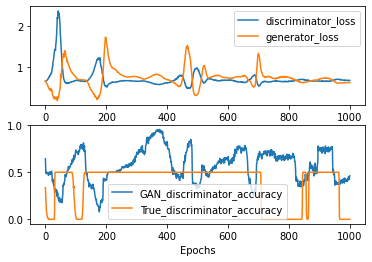

1875/1875 [==============================] - 5s 3ms/step


C:\Windows\Temp\ipykernel_22888\3476477901.py:192: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruex_final = pd.DataFrame(output_true_upsampled_x).append(pd.DataFrame(output_noise_x),ignore_index = True).to_numpy()
C:\Windows\Temp\ipykernel_22888\3476477901.py:193: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  distruey_final = pd.DataFrame(output_true_upsampled_y).append(pd.DataFrame(output_noise_y),ignore_index = True).to_numpy()


Final True Discriminant Accuracy: 0.180


In [34]:
disc2 = discriminatortrue(output_model_noise.shape[1])
disc = discriminator(output_model_true.shape[1])
gen = generator(output_model_true.shape[1])
gan = GAN(gen,disc)
train(gen,disc,disc2,gan,output_model_noise,output_model_true,n_epochs = 1000)

1875/1875 [==============================] - 6s 3ms/step


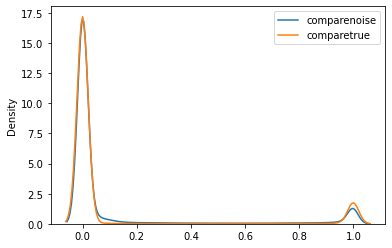

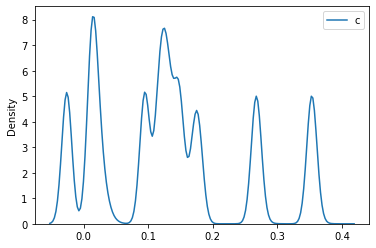

In [36]:
noise = np.random.randn(output_model_noise.shape[0],output_model_noise.shape[1])
noise = np.expand_dims(noise, axis=2)
comparenoise = output_model_noise.flatten()
comparetrue = output_model_true.flatten()
comparefake = gen.predict(noise).flatten()
sns.kdeplot(comparenoise)
sns.kdeplot(comparetrue)
plt.legend(labels = ['comparenoise','comparetrue'])
plt.show()
sns.kdeplot(comparefake)
plt.legend(labels = 'comparefake')
plt.show()

In [38]:
from scipy.stats import ttest_ind

ttest_ind(comparetrue,comparefake)

Ttest_indResult(statistic=-72.06742595980404, pvalue=0.0)